#  Plot the data used as input for the 0D model


We will train a model which describes the electroweak production of a Z boson in association with 2 jets. We aim to describe many observables simultaneously. This model has no external parameter dependence.

This experiment demonstrates that our method is capable of describing the PDF of many correlated physical observables, whilst respecting the intervals over which tnhey are defined.

Such a model could be used to perform a goodness-of-fit test to the data, or act as a stochastic generator. Such a generator may be considered for use at any stage of a simulation chain (e.g. parton level event generation, parton showering, calorimeter response).

In this notebook, we will load and plot the input data. We will consider 12 observables:
- $\Delta\phi~(j,j)$
- $\Delta y~(j,j)$
- $N_{\rm gap~jets}$  [integer]
- $N_{\rm jets}$   [integer]
- $m_{jj}$
- $p_{T}^{j1}$
- $p_{T}^{j2}$
- $p_{T}^{jj}$
- $p_{T}^{ll}$
- $|y_{jj}|$
- $|y_{ll}|$

We note that there are some physical constraints which relate several observables, namely
- $N_{\rm jets} ~~\geq~~ N_{\rm gap~jets}$
- $p_{T}^{j1} ~~\geq~~ p_{T}^{j2}$
- $p_{T}^{jj} ~~\leq~~ p_{T}^{j1} ~+~ p_{T}^{j2}$
- $\Delta y~(j,j) ~~\leq~~ 8.8 ~-~ 2\times|y_{jj}|$

We will not apply co-ordinate transformations to enforce these constraints, because such an approach would violate the interval boundaries for the non-transformed observables.

Initially we will simply 

In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename, joint_shuffle

from backends import plot as plot, density_model as density_model, VBFZ_analysis as VBFZ


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends



As input we will use 1M electroweak events. We will split this into 70% training and 30% validation data. We will not use a statistically independent test dataset, since we will not evaluate accuracy metrics to assess the model performance. Instead we will study  the ratio between the simulated datapoints and datapoints sampled from the density model.


In [2]:
#  Inputs config

input_fname = "../Data/SM_EWK_1M_rivet_output.pickle"


In [3]:
#  Configure VBFZ observables
remove_observables = []
VBFZ.configure(remove_observables)
print(f"Configured with {VBFZ.num_observables} observables: " + ", ".join(VBFZ.observables))

#  Configure plot functions with observable information
plot.int_observables   = VBFZ.int_observables
plot.observable_limits = VBFZ.transformed_observable_limits

#  Load and format the data
data_table = VBFZ.load_table(input_fname, transform=True)


Configured with 12 observables: Dphi_j_j, Dy_j_j, N_gap_jets, N_jets, m_jj, m_ll, pT_j1, pT_j2, pT_jj, pT_ll, rap_jj, rap_ll
Loading events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 640713 events survived
 -- filtering observable pT_j2 between 40 and 1200

####  Plot data on transformed observable space

Let us plot our data distributions to get a feeling for how they are distributed before we project onto the latent space.

In [4]:
#  Make persistent copy of transformed data

physical_data, weights = data_table.get_observables_and_weights()
transformed_data   = VBFZ.transform_observables_fwd (physical_data   , data_table.keys)
untransformed_data = VBFZ.transform_observables_back(transformed_data, data_table.keys)

#  Check closure of fwd/back transformations

for row, key in zip((untransformed_data/physical_data).transpose(), data_table.keys) :
    row = [r for r in row if r > 0]
    print(f"Observable {key} closure is {np.mean(row):.5f} +- {np.std(row):.5f}     (should be 1 +- 0)")


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Observable Dphi_j_j closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable Dy_j_j closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable N_gap_jets closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable N_jets closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable m_jj closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable m_ll closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable pT_j1 closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable pT_j2 closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable pT_jj closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable pT_ll closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable rap_jj closure is 1.00000 +- 0.00000     (should be 1 +- 0)
Observable rap_ll closure is 1.00000 +- 0.00000     (should be 1 +- 0)


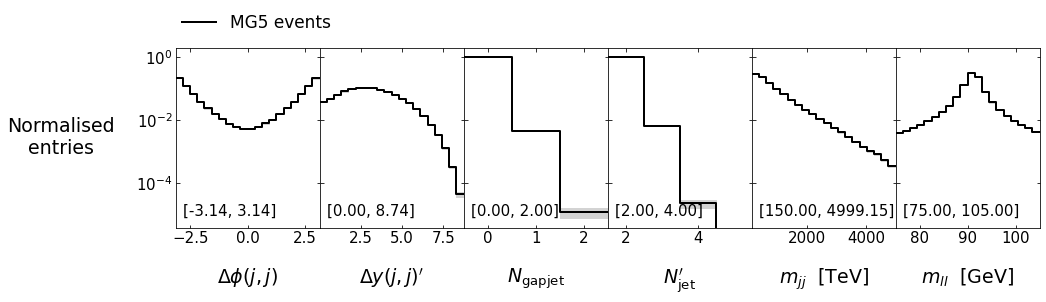

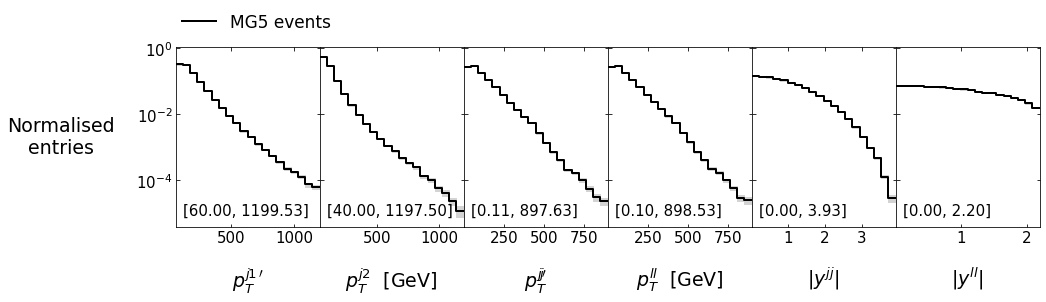

In [5]:
#  Plot 1D projections

def plot_1D_projections (plot_observables, save_fname) :
    
    data = transformed_data
    
    plot_num_observables = len(plot_observables)
    
    fig = plt.figure(figsize=(2*plot_num_observables, 5))
    
    axes1, ylos, yhis = [], [], []
    for plot_idx, observable in enumerate(plot_observables) :

        #  Get axis x coordinates
        xlo    = plot_idx / plot_num_observables
        xwidth = 1.       / plot_num_observables

        #  Create axis
        ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])

        #  Set axis limits
        obs_idx  = VBFZ.observables.index(observable)
        obs_lims = VBFZ.transformed_observable_limits[observable]
        num_bins = 20
        xlo, xhi = np.min(data[:,obs_idx]), np.max(data[:,obs_idx])
        if observable in VBFZ.int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 2+(obs_lims[1]-obs_lims[0]))
        else                                  : bins = np.linspace(xlo, xhi, num_bins+1)

        #  Plot data
        hvals1, _ = np.histogram(data[:,obs_idx], bins=bins, weights=weights        )
        herrs1, _ = np.histogram(data[:,obs_idx], bins=bins, weights=weights*weights)
        herrs1    = np.sqrt(herrs1)
        hvals1, herrs1 = hvals1/np.sum(weights), herrs1/np.sum(weights)

        plot_x, plot_y1, plot_ey1 = plot.histo_to_line(bins, hvals1, herrs1)

        ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="MG5 events")
        ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
        ax1.set_yscale("log")

        # Save y values range
        ylo, yhi = np.min([yp for yp in plot_y1-plot_ey1 if yp > 0]), np.max(plot_y1+plot_ey1)
        ylos.append(ylo)
        yhis.append(yhi)

        #  Set x axis labels
        ax1.set_xlabel(VBFZ.get_transformed_obs_label(observable), fontsize=19, labelpad=20)

        #  Set y axis labels
        if plot_idx == 0 : 
            ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
            ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
        
        if plot_idx > 0 :
            ax1.get_yaxis().set_ticklabels([])

        #  Set x limits
        ax1.set_xlim([bins[0], bins[-1]])

        #  Set tick params
        ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
        ax1.text(0.05, 0.05, f"[{xlo:.2f}, {xhi:.2f}]", ha="left", va="bottom", fontsize=15, transform=ax1.transAxes)

        #  Save axes
        axes1.append(ax1)

    #  Set consistent axis y lims
    for ax in axes1 :
        ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

    #  Save and show plot
    make_sure_dir_exists_for_filename(save_fname)
    plt.savefig(save_fname, bbox_inches="tight")
    plt.show()
    
plot_1D_projections(VBFZ.observables[:6], f"figures/Auxilliary/1D_distributions_transformed_distributions_row1.pdf")
plot_1D_projections(VBFZ.observables[6:], f"figures/Auxilliary/1D_distributions_transformed_distributions_row2.pdf")
 

Filter efficiency is 100.000%


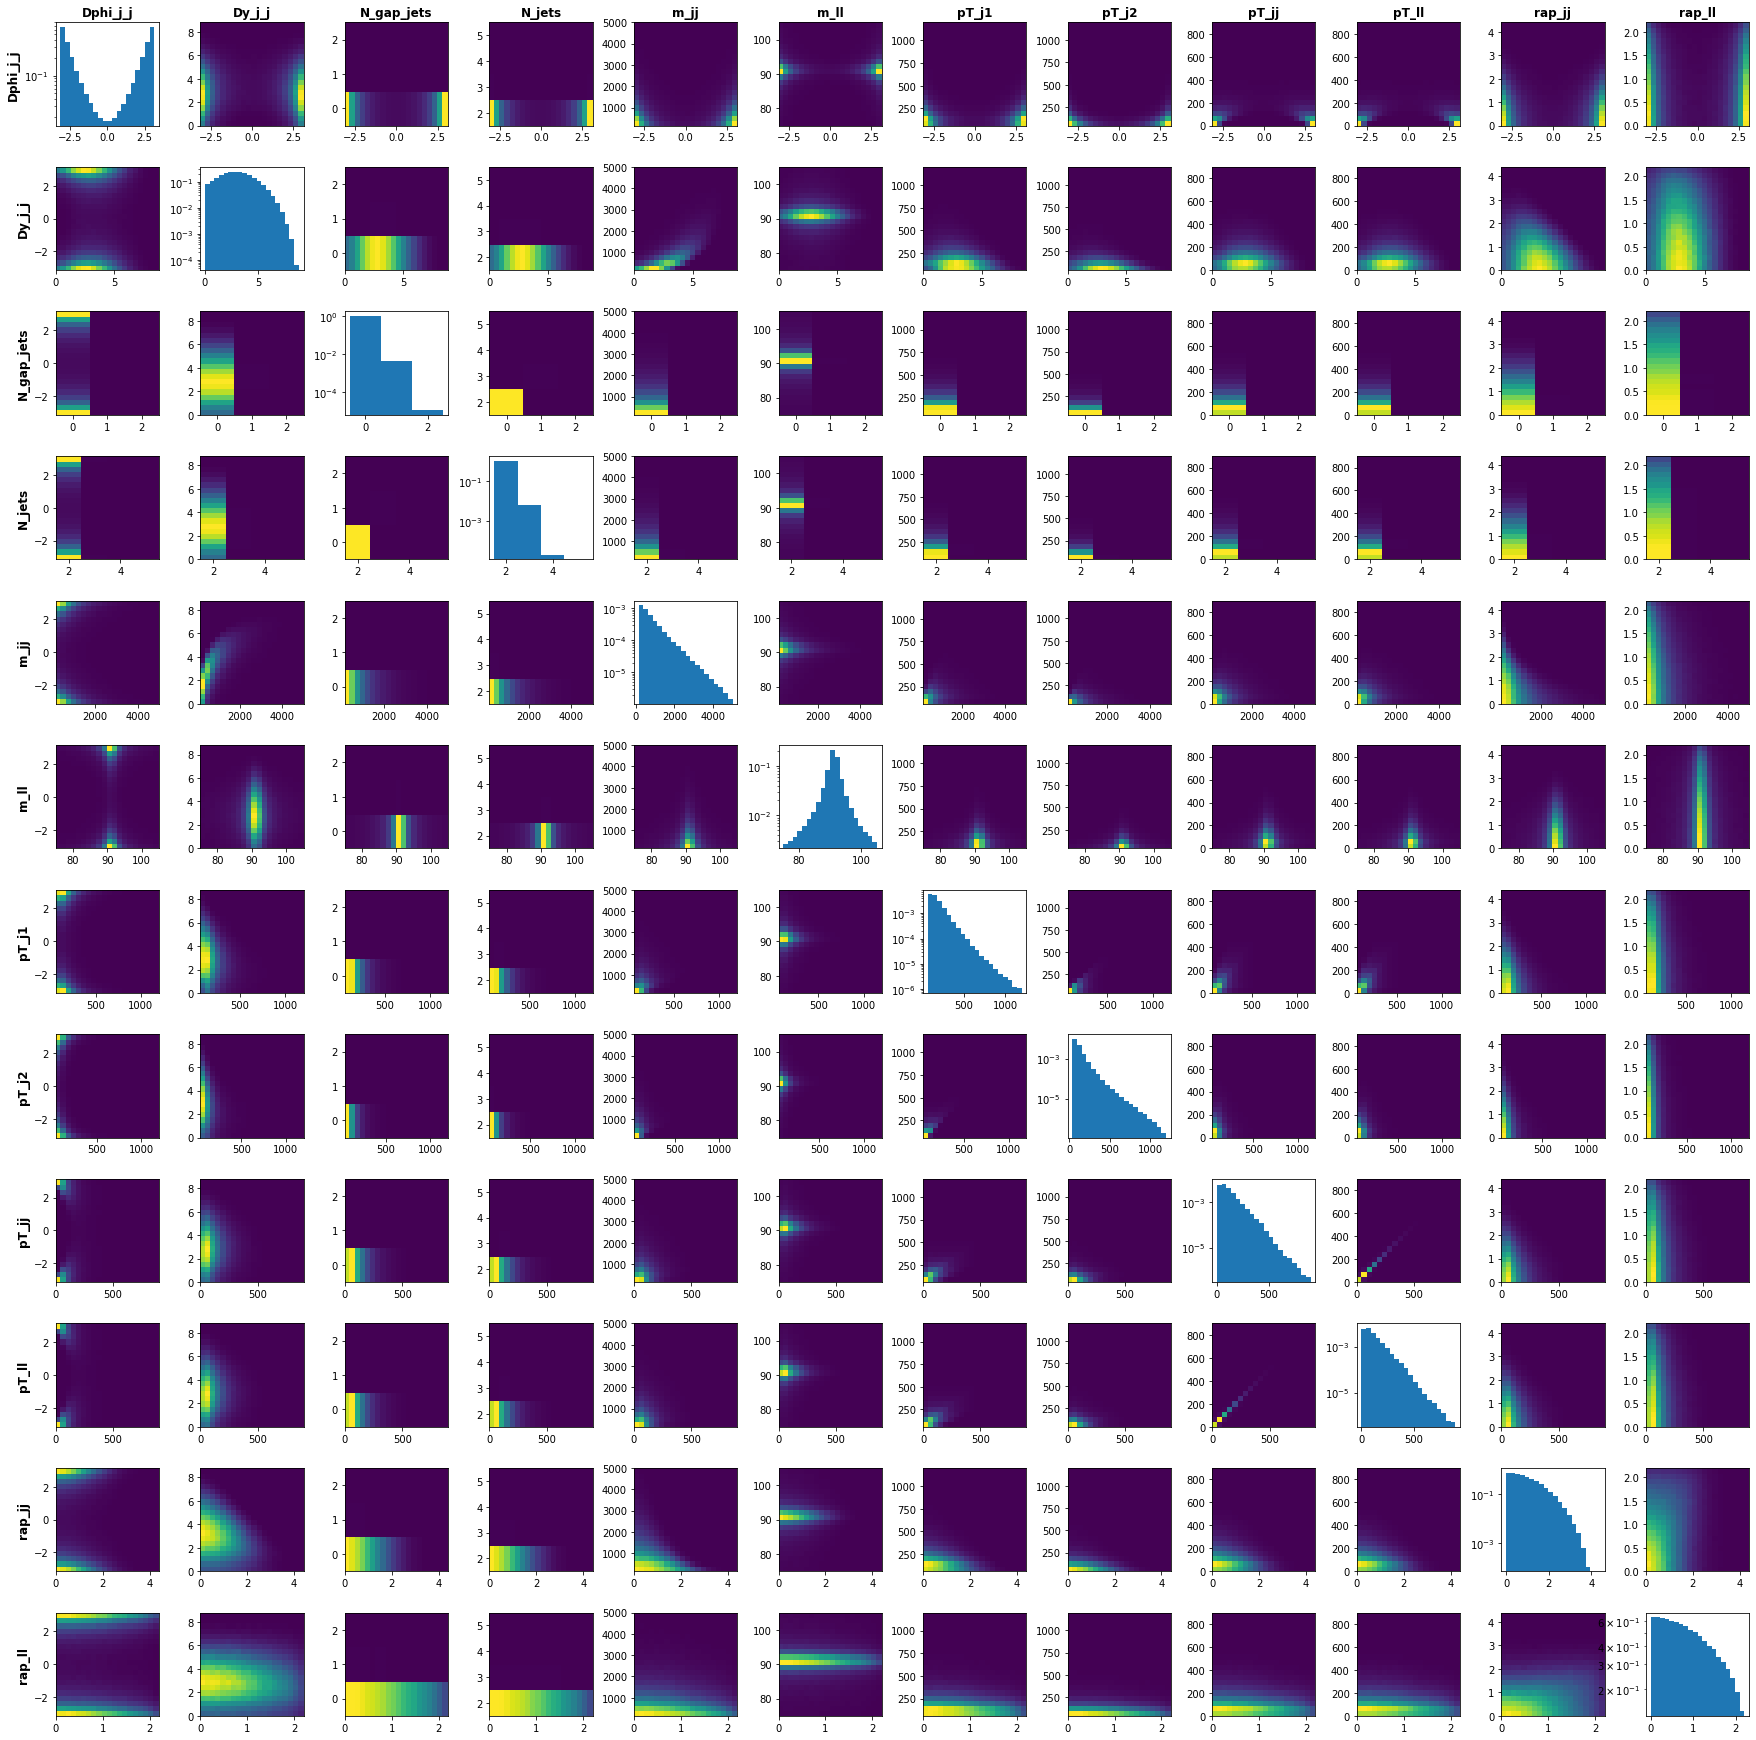

In [6]:
#  Plot 2D projections (transformed observables)

plot_data(data_table.data, data_table.get_weights(), keys=data_table.keys, bins=20, lims=True)


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/VBFZ_analysis.py:285: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=vmin, vmax=1, norm=colors.LogNorm())


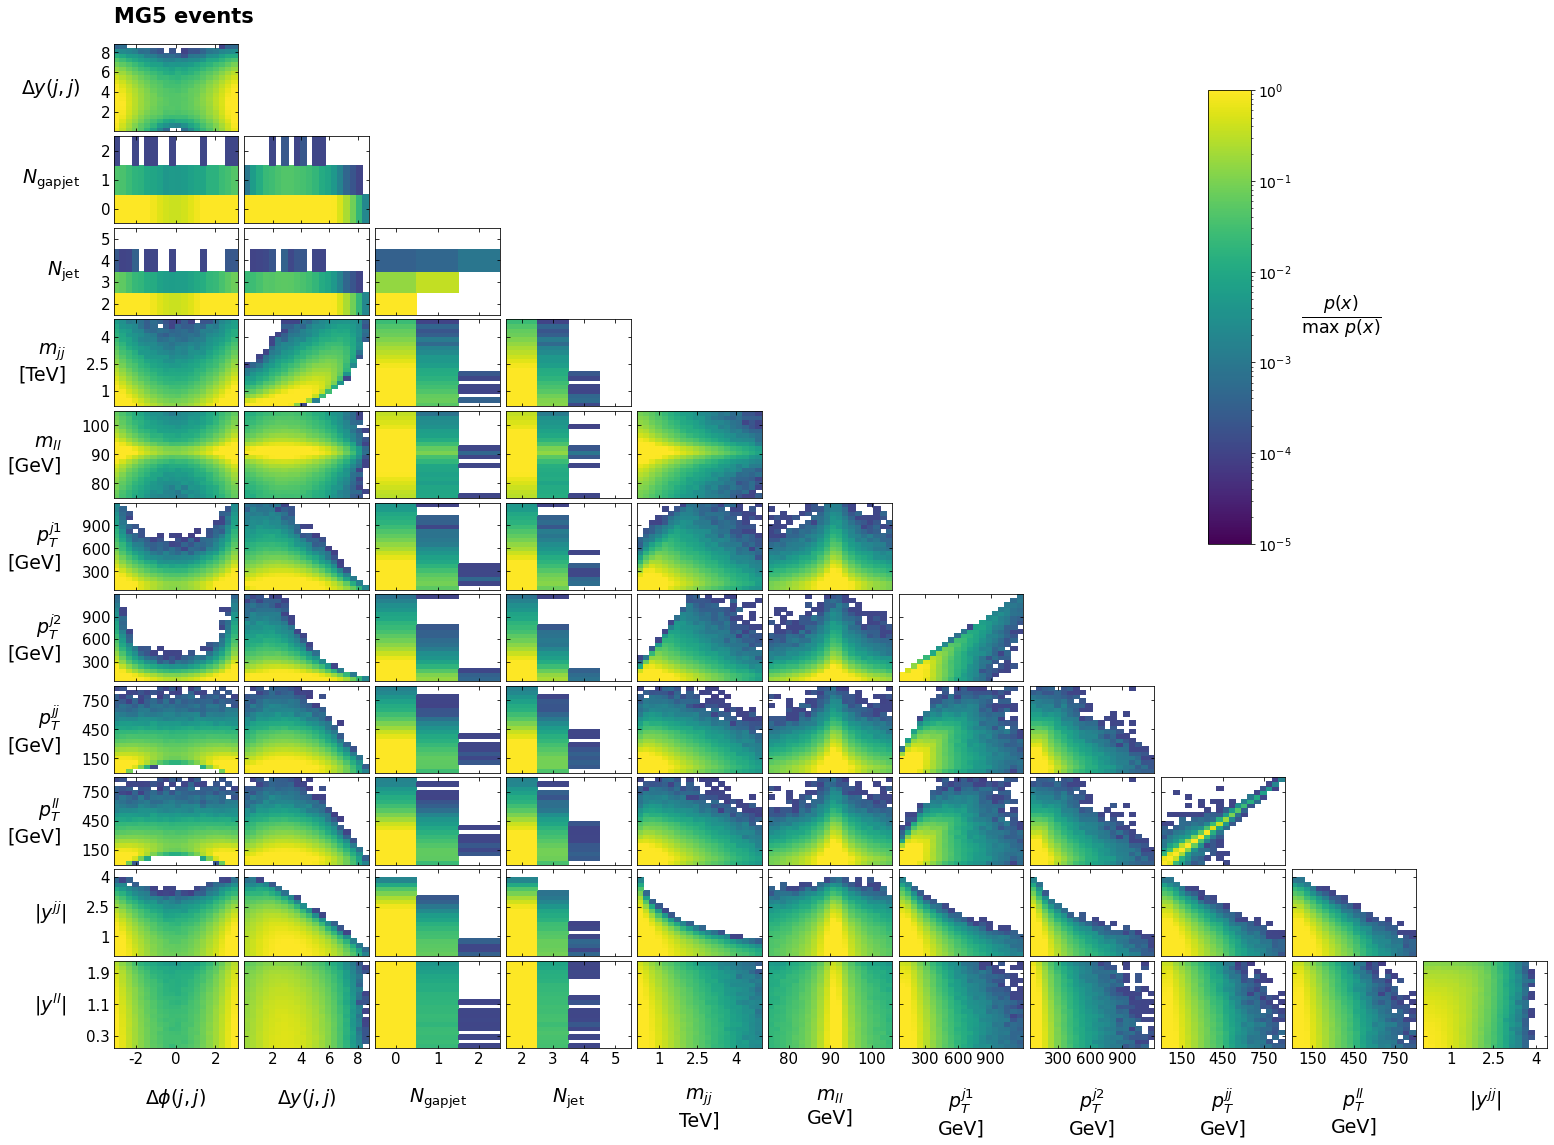

In [7]:
#  Plot 2D projections (physical observables)

VBFZ.plot_2D_projections(physical_data, weights, label="MG5 events", savefig=f"figures/Auxilliary/2D_distributions_MG5.pdf")
